# Using Knetminer SPARQL with Jupyter, a Demo

With Knetminer available as SPARQL, we can do our own data analyses, without being constrained on 
the [Knetminer web application only][TODO]  

Here it is a simple exmple. Let's do some investigation on the question: which biological 
processes are involved in yellow rust?  

One way to figure out an answer is to start from genes mentioned in publications, then follow the 
proteins encoded by such genes, and see the GO biological processes those proteins are annotated
with.  

If we look ad the [knowledge graph that Knetminer has for wheat][TODO], we soon discover that 
actually we also have to consider proteins related to gene-encoded proteins, since proteins with 
similar sequences or other public cross references are often relevant.  

In SPARQL and using our [BioKNO Ontology][TODO], this translates to the following query:

In [1]:
query = """
PREFIX bk: <http://knetminer.org/data/rdf/terms/biokno/>
PREFIX bkr: <http://knetminer.org/data/rdf/resources/>
PREFIX bka: <http://knetminer.org/data/rdf/terms/biokno/attributes/>
PREFIX bkg: <http://knetminer.org/data/rdf/resources/graphs/>

SELECT DISTINCT ?bioProcName (COUNT (?geneName) AS ?genes)
FROM bkg:wheat # The endpoint has many datasets, we're looking into wheat only
WHERE
{
  # The publications of interest
  ?pub a bk:Publication;
    bka:AbstractHeader ?title;

  FILTER ( CONTAINS ( ?title, "yellow rust" ) )

  # The genes mentioned by the publications
  ?gene bk:occ_in ?pub;
    a bk:Gene;
    bk:prefName ?geneName.
  
  # They encode proteins and there might be related proteins. Let's consider relation chains of
  # 0 (the encoded protein is directly involved) to 2.
  # predicates are repeated with the ^ prefix, to consider both directions
  # h_s_s := "has similar sequence"
  ?gene bk:enc ?protein.
  ?protein (bk:h_s_s|bk:xref|bk:ortho|^bk:h_s_s|^bk:xref|^bk:ortho){0,1} ?rprotein.

  ?rprotein bk:participates_in ?bioProc.
  
  ?bioProc bk:prefName ?bioProcName.
}
GROUP BY ?bioProcName
ORDER BY DESC ( ?genes )
LIMIT 100
"""

Now we can invoke the query against our endpoint, using the SPARQLWrapper libray. Let's also convert the result to a convenient matrix and render it as a nice table.

In [2]:
from SPARQLWrapper import SPARQLWrapper2

# Go with the query
sparql = SPARQLWrapper2 ( "http://knetminer-data.cyverseuk.org/lodestar/sparql" )
sparql.setQuery ( query )

# Clean it up
result = sparql.query().bindings
result = [ [ r['bioProcName'].value, int ( r['genes'].value ) ] for r in result ]

# Render nicely
import pandas as pd
dframe = pd.DataFrame ( result, columns = [ "GO Bio Proc", "# Genes" ] )
display ( dframe )

,GO Bio Proc,# Genes
0,Brassinosteroid Mediated Signaling Pathway,60
1,Protein Phosphorylation,53
2,Nodulation,36
3,Innate Immune Response,33
4,Detection Of Brassinosteroid Stimulus,26
5,Regulation Of Seedling Development,24
6,Brassinosteroid Homeostasis,24
7,Positive Regulation Of Flower Development,24
8,Pollen Exine Formation,24
9,Microtubule Bundle Formation,24


Cool! Let's see them better in a chart:

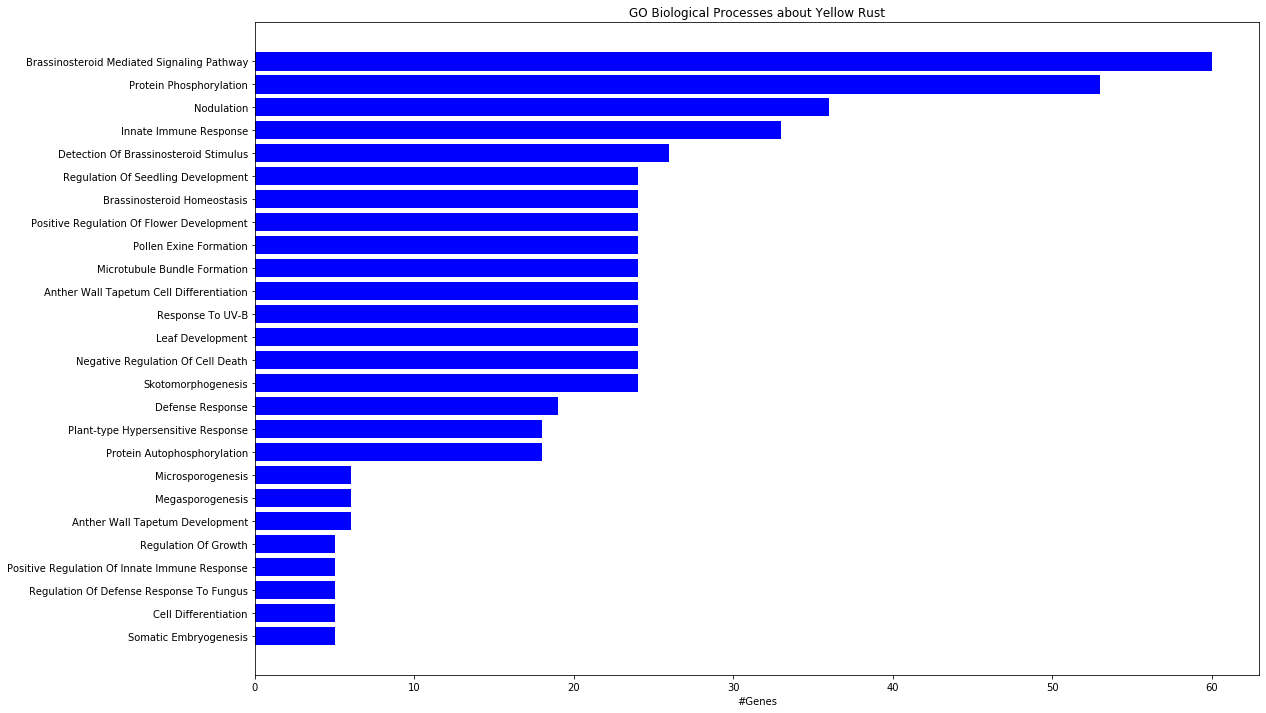

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
import textwrap

# Let's fix a few visualisation things
#plt.rcParams [ "font.size" ] = "20"

# Including figure size
figsz = plt.gcf().get_size_inches()
plt.gcf().set_size_inches ( figsz * 3 ) 


# These labels are way too long, let's massage them
#ylabels = [ textwrap.shorten ( row [ 0 ], 
#                              width = 60, fix_sentence_endings = True, placeholder = '...' ) \
#            for row in result ]
ylabels = [ row [0] for row in result ]
values = [ row [ 1 ] for row in result ]

# Order them in descendant way, probably there are better ways to do it in mathplot...
ypos = [ len( ylabels ) - 1 - i for i, _ in enumerate ( ylabels ) ]

# An horizontal bar chart
plt.barh ( ypos, values, color = 'blue' )
#plt.ylabel ( "GO Bio Proc" )
plt.xlabel( "#Genes" )
plt.title ( "GO Biological Processes about Yellow Rust" )
plt.yticks( ypos, ylabels )

plt.show()